# Concept Distance vs Accuracy

Many text mining algorithms for semantic annotation tokenize at the sentence level.  This script investigates the relationship annotations that may be missed when concept relationships are presented to annotators at the sentence-level, and inspects the effect of concept distance on the accuracy of the relationship annotation. To do this, the abstracts are tokenized at the sentence level to obtain an average per-sentence character count which can be used to estimate the concept distance at the sentence level.  Only concepts with known identifiers were analyzed as it would be more difficult to determine the positional location of a term in an abstract when the identifier is missing.

Since discarding the concept annotation should not be affected by concept distance,relation annotations in concepts considered 'not broken' will be treated separately in this analysis

## Import modules and data

In [8]:
import pandas
import random
import matplotlib
from matplotlib import pyplot as mplot
import m2c_rel_basic
import relationship_dictionaries
from pandas import read_csv

Import the relationship annotations data for only completed concept pairs, for which every concept has an associated identifier.

In [9]:
savepath = 'data/'
exppath = 'exports/'
all_completed_id_anns = read_csv(savepath+'all_completed_anns.txt', delimiter='\t', header=0)
all_completed_id_anns.drop("Unnamed: 0",axis=1,inplace=True)

In [10]:
rel_hash_dict,redundant_response_dict,abbreviated_rels_dict,abbreviated_rels_dict_4_hash,concept_broken_dict,concept_not_broken_dict = relationship_dictionaries.load_RE_dictionaries()

Import the processed pubtator concept annotations and tokenized pmid data from the notebook on Investigating Concept Annotations

In [11]:
#conceptsource = 'concepts_anns_from_db.txt'
pubsource = 'concept_anns_from_updated_pub_files.txt'
concept_imported = read_csv(savepath+pubsource, delimiter='\t', header=0)
concept_imported.drop("Unnamed: 0",axis=1,inplace=True)

tokenize_sum = read_csv(exppath+'tokenized_pmids.txt',delimiter='\t', header=0)
tokenize_sum.drop("Unnamed: 0",axis=1,inplace=True)

Import the QC'd annotations

In [12]:
esample_df = m2c_rel_basic.get_QC_data(savepath)

## Analyze the imported data for concept distance

#### Format the imported concept annotation data to include annotation end positions

In [13]:
concept_imported['endset'] = concept_imported['offset']+concept_imported['length']
print(concept_imported.head(n=3))

       pmid                                  text     identifier type  offset  \
0  19067230                 hypertransaminasaemia  no identifier    d      19   
1  19067230  congenital disorder of glycosylation        D018981    d      51   
2  19067230                        Wilson disease        D006527    d     321   

   length  endset  
0      21      40  
1      36      87  
2      14     335  


In [14]:
#### Copy slices/aggregations of the dataframe for downstream analysis without having to worry about the .loc exception
cp_pair_counts = all_completed_id_anns.groupby(['pmid','concept_pair','reltype','refid1','refid2']).size().reset_index(name='completion_count')
cp_pair_counts['pmid'] = cp_pair_counts['pmid'].astype(str)

maxagree_result = cp_pair_counts.copy()
pubtator_key = concept_imported.copy()

In [15]:
print(maxagree_result.head(n=2))

      pmid       concept_pair reltype   refid1   refid2  completion_count
0  1299347  C095810_x_D008232     c_d  C095810  D008232                15
1  1299347  D005944_x_D008232     c_d  D005944  D008232                15


In [16]:
##import the annotations that were manually mapped after being dropped by pubtator (these are generated from the 'Mapping Dropped Concepts Script')
dropped_anns_offsets_src = 'dropped_anns_offsets.txt'
dropped_anns_offsets = read_csv(savepath+dropped_anns_offsets_src, delimiter='\t', header=0)
dropped_anns_offsets.drop("Unnamed: 0",axis=1,inplace=True)
dropped_anns_offsets['pmid'] = dropped_anns_offsets['pmid'].astype(str)
dropped_anns_offsets['offset'] = dropped_anns_offsets['offset'].astype(int)
dropped_anns_offsets['endset'] = dropped_anns_offsets['endset'].astype(str)
dropped_anns_offsets_found = dropped_anns_offsets.loc[dropped_anns_offsets['offset']!=-1]
dropped_anns_offsets_not_found = dropped_anns_offsets.loc[dropped_anns_offsets['offset']==-1]
print(dropped_anns_offsets_found.head(n=2))

   appear_no               cptext endset                  exact identifier  \
0          0  glycosylated lysine    365   glycosylated lysine     C039522   
1          2  glycosylated lysine   1932   glycosylated lysine     C039522   

   length  offset    pmid type  
0      19     346  501285    c  
1      19    1548  501285    c  


In [17]:
## for each pmid, pull out the concept pairs from the pubtator table
## check the distance between concept1 and concept 2, and save the smallest distance

n=0
mindiff_list = []
z = len(maxagree_result)

while n<z:
    testrefid1 = maxagree_result.iloc[n]['refid1']
    testrefid2 = maxagree_result.iloc[n]['refid2']
    testpmid = str(cp_pair_counts.iloc[n]['pmid'])
    tmpdict = {'pmid':testpmid,
               'refid1':testrefid1,
               'refid2':testrefid2,
               'concept_pair':maxagree_result.iloc[n]['concept_pair'],
               'no_times_complete':maxagree_result.iloc[n]['completion_count']
               }
    i = 0
    j = 0
    offdiff = []
    mindiff = 0
    cp1 = pubtator_key.loc[(pubtator_key['pmid'].astype(str)==testpmid)&(pubtator_key['identifier']==testrefid1)]
    cp2 = pubtator_key.loc[(pubtator_key['pmid'].astype(str)==testpmid)&(pubtator_key['identifier']==testrefid2)]
    cp1_bkup = dropped_anns_offsets_found.loc[(dropped_anns_offsets_found['pmid']==testpmid)&(dropped_anns_offsets_found['identifier']==testrefid1)]
    cp2_bkup = dropped_anns_offsets_found.loc[(dropped_anns_offsets_found['pmid']==testpmid)&(dropped_anns_offsets_found['identifier']==testrefid1)]
    if (len(cp1) == 0) and (len(cp1_bkup)==0):
        mindiff = -1
        tmpdict['min_diff']=mindiff
        tmpdict['notes']=testrefid1+' (cp1) removed not salvaged'
        mindiff_list.append(tmpdict)
        n=n+1    
    elif (len(cp2) == 0) and (len(cp2_bkup)==0):
        mindiff = -1
        tmpdict['min_diff']=mindiff
        tmpdict['notes']=testrefid2+' (cp2) removed not salvaged'
        mindiff_list.append(tmpdict)
        n=n+1     
    else:
        minset=set()
        salvaged = False
        cp1a_set = set(cp1['endset'].tolist()) ## create the set of offset and endset values for cp1 and cp2
        if len(cp1a_set)==0:
            cp1a_set = set(cp1_bkup['endset'].tolist()) ## create the set of offset and endset values for cp1 and cp2
            salvaged = True
        cp2a_set = set(cp2['offset'].tolist()) ## assuming that concept 1 appears before concept 2
        if len(cp2a_set)==0:
            cp2a_set = set(cp2_bkup['endset'].tolist()) ## create the set of offset and endset values for cp1 and cp2
            salvaged = True
        cp1b_set = set(cp1['offset'].tolist()) ## create the set of offset and endset values for cp1 and cp2
        if len(cp1b_set)==0:
            cp1b_set = set(cp1_bkup['endset'].tolist()) ## create the set of offset and endset values for cp1 and cp2
            salvaged = True
        cp2b_set = set(cp2['endset'].tolist()) ## assuming that concept 2 appears before concept 1
        if len(cp2b_set)==0:
            cp2b_set = set(cp2_bkup['endset'].tolist()) ## create the set of offset and endset values for cp1 and cp2
            salvaged = True
        #create a combination of values between the the endsets and offsets
        if (len(cp1a_set)+len(cp1b_set)+len(cp2a_set)+len(cp2b_set) == 0) and salvaged==False:
            tmpdict['notes']='dropped, not salvaged'
            tmpdict['min_diff']='concept dropped'
            mindiff_list.append(tmpdict)
            n=n+1  
        else:
            if salvaged==True:
                tmpdict['notes']='at least 1 dropped, salvaged'
            else:
                tmpdict['notes']='none dropped, not salvaged'
            tmppdf1 = pandas.DataFrame([(endset,offset) for endset in cp1a_set for offset in cp2a_set]) #cp1 first then cp2
            tmppdf2 = pandas.DataFrame([(endset,offset) for offset in cp1b_set for endset in cp2b_set]) #cp2 first then cp1
            tmppdf1['c1_first'] = tmppdf1[1].astype(int)-tmppdf1[0].astype(int)
            tmppdf2['c2_first'] = tmppdf2[1].astype(int)-tmppdf2[0].astype(int)
            mindiff1 = tmppdf1.loc[tmppdf1['c1_first']>0]
            mindiff2 = tmppdf2.loc[tmppdf2['c2_first']>0]
            if len(mindiff1)>0:
                minset.add(mindiff1.c1_first.min())
            if len(mindiff2)>0:
                minset.add(mindiff2.c2_first.min())
            if len(minset)>1:
                mindiff = min(minset)
            elif len(minset)==1:
                mindiff = list(minset)[0]
            else:
                mindiff = -1
            tmpdict['min_diff']=str(mindiff)
            mindiff_list.append(tmpdict)
            n=n+1

mindiff_df = pandas.DataFrame(mindiff_list)


In [18]:
## remove the unsalvaged annotations from the concept distance calculations
concept_distance = mindiff_df.loc[(mindiff_df['min_diff']!=-1)&(mindiff_df['min_diff']!='-1')]
print('concept pairs to check for concept distance: ',len(maxagree_result))
print('concept pairs less unsalvageable concepts: ',len(concept_distance))
print(concept_distance.head(n=2))

concept pairs to check for concept distance:  1009
concept pairs less unsalvageable concepts:  699
        concept_pair min_diff  no_times_complete                       notes  \
0  C095810_x_D008232      322                 15  none dropped, not salvaged   
1  D005944_x_D008232      562                 15  none dropped, not salvaged   

      pmid   refid1   refid2  
0  1299347  C095810  D008232  
1  1299347  D005944  D008232  


In [19]:
#### Merge the concept distance data with the tokenized abstract data
concept_distance['pmid'] = concept_distance['pmid'].astype(int)
tokenize_sum['pmid'] = tokenize_sum['pmid'].astype(int)
concept_dist_df = concept_distance.merge(tokenize_sum,on='pmid', how='left')
concept_dist_df['sent_diff'] = concept_dist_df['min_diff'].astype(float).div(concept_dist_df['char_p_sent'])
concept_dist_df['word_diff'] = concept_dist_df['min_diff'].astype(float).div(concept_dist_df['char_p_word'])
#print(concept_dist_df.head(n=2))

concept_dist_to_check = concept_dist_df[['pmid','refid1','refid2','notes','min_diff','sent_diff','word_diff']].copy()
concept_dist_to_check['cpmid']=concept_dist_to_check['pmid'].astype(str).str.cat(concept_dist_to_check['refid1'].astype(str).str.cat(concept_dist_to_check['refid2'], sep='_x_'), sep='_')
concept_dist_to_check.sort_values(['cpmid','min_diff'],ascending=(True,True),inplace=True)
print(concept_dist_to_check.head(n=2))

        pmid refid1   refid2                         notes min_diff  \
57  10068747   5443  C536008  at least 1 dropped, salvaged     1218   
58  10068747   5443  D000309  at least 1 dropped, salvaged      279   

    sent_diff   word_diff                    cpmid  
57  14.024180  189.326425  10068747_5443_x_C536008  
58   3.212435   43.367876  10068747_5443_x_D000309  


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Analyze for Accuracy relative to the QC'd set.

Note which cpmids should vs shouldn't be marked as broken; note which concept pairs were determined to have 'no relationship'; and get the cpmids from the remaining QC'd annotations and create the test set from them.

In [34]:
esample_df['conclusion'].replace(abbreviated_rels_dict_4_hash, inplace=True)
esample_df['conclusion'].replace(concept_broken_dict, inplace=True)
not_broken = esample_df.loc[esample_df['conclusion']!='concept_broken'].copy()

no_relation = esample_df.loc[esample_df['conclusion'].str.contains('unrelated')].copy()
related = esample_df.loc[(esample_df['conclusion']!='concept_broken')&
                         (~esample_df['conclusion'].str.contains('unrelated'))].copy()
                                                                   
test_set_cpmids = set(esample_df['cpmid'].tolist())

11
58


Use the cpmids to pull the user annotations for quality checking

In [23]:
total_ref_set = all_completed_id_anns.loc[all_completed_id_anns['cpmid'].isin(test_set_cpmids)].copy()
total_ref_set['evtype'].replace(abbreviated_rels_dict_4_hash, inplace=True)
total_ref_set['evtype'].replace(concept_broken_dict, inplace=True)

Check the inclusion of the reference cpmids in the test set

In [25]:
print('number of Non-broken QC annotations: ',len(test_set_cpmids))
tokenize_test_set = concept_dist_to_check.loc[concept_dist_to_check['cpmid'].isin(test_set_cpmids)]
print('number of QC cpmids in the tokenized abstract set', len(tokenize_test_set))

number of Non-broken QC annotations:  116
number of QC cpmids in the tokenized abstract set 80


### Subsample the results to determine how voting threshold (k) affects accuracy

In [26]:
#### Sampling the responses and putting into a dataframe, 10 iterations per k per cpmid
#### repeating the sampling 5 times to stabilize the results
#### This is the slowest part of the code; hence, a print statement has been left in so you know it's working
k=1
majority_response=[]
j=0
problem_cpmids = []
cp_dist_issues = []

while j<5:
    i=0
    print('repetition:',j)
    while i<10:
        k=1
        while k<16:
            for each_cpmid in test_set_cpmids:
                result_dict = {}
                result_dict['repetition'] = j
                result_dict['iteration'] = i
                result_dict['cpmid'] = each_cpmid
                result_dict['k'] = k
                try:
                    tmp_df = total_ref_set.loc[total_ref_set['cpmid']==each_cpmid]
                    user_set = set(tmp_df['user_id'].tolist())
                except: 
                    problem_cpmids.append(each_cpmid)
                    user_set=set()                   
                if k<=len(user_set):
                    user_sample = random.sample(user_set, k)
                    ref_sample = tmp_df.loc[tmp_df['user_id'].isin(user_sample)]
                    if k == 1:
                        result_dict['response'] = ref_sample.iloc[0]['evtype']
                        result_dict['majority?'] = 'yes'
                        result_dict['tie?'] = 'no'
                        result_dict['result_selection'] = 'single_vote'
                    else:
                        ## Groupby response and get biggest and next biggest value    
                        ref_sample_size = ref_sample.groupby(['cpmid','evtype']).size().reset_index(name='counts')
                        ref_sample_size.sort_values('counts', ascending=False, inplace=True)
                        first_most = ref_sample_size.iloc[0]['counts']
                        try:
                            sec_most = ref_sample_size.iloc[1]['counts'] ##if this works, results are not unanimous
                            if first_most > sec_most: ## If there is a majority
                                result_dict['majority?'] = 'simple_majority'
                                result_dict['result_selection'] = 'majority'
                                result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                                result_dict['tie?'] = 'no'
                            else: ## else it's a tie
                                result_dict['majority?'] = 'no_majority'
                                result_dict['result_selection'] = 'random'
                                if len(ref_sample_size)==2: ## check if full tie
                                    rand_option = random.randint(0, 1)
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = 'two_way'
                                elif (len(ref_sample_size) > 2) & (sec_most > ref_sample_size.iloc[3]['counts']): #check if majority tied
                                    rand_option = random.randint(0, 1)
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = 'top_two_way'
                                elif (len(ref_sample_size) > 2) & (sec_most == ref_sample_size.iloc[3]['counts']): #check for 3-way tie                      
                                    rand_option = random.randint(0, 2)
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = '3_way'
                                else:    
                                    rand_option = random.randint(0, len(ref_sample_size))
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = 'other'
                        except: ## Scenario: results are unanimous
                            result_dict['majority?'] = 'unanimous'
                            result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                            result_dict['tie?'] = 'no'
                            result_dict['result_selection'] = 'majority'
                else:
                    result_dict['majority?'] = 'n/a'
                    result_dict['response'] = 'not_enough'
                    result_dict['tie?'] = 'n/a'
                    result_dict['result_selection'] = 'n/a' 
                ## check how well user response matched expert response
                tmp_edf = esample_df.loc[esample_df['cpmid']==each_cpmid]           
                test_response = result_dict.get('response')
                expert_response = tmp_edf['conclusion'].iloc[0]
                if test_response=='not_enough':
                    result_dict['expert_match?'] = 'n/a'
                elif test_response == expert_response:
                    result_dict['expert_match?'] = 'yes'
                else:
                    result_dict['expert_match?'] = 'no'
                majority_response.append(result_dict) 
            k = k+1
        i=i+1
    j=j+1
    

majority_df = pandas.DataFrame(majority_response)

print(majority_df.head(n=5))
#majority_df.to_csv(exppath+'accuracy_for_concept_distance.txt',sep='\t',header=True)

repetition: 0
repetition: 1
repetition: 2
repetition: 3
repetition: 4
                        cpmid expert_match?  iteration  k majority?  \
0     11353896_5443_x_D020022            no          0  1       yes   
1      1325164_5443_x_C536008            no          0  1       yes   
2     16051600_None_x_D018981            no          0  1       yes   
3  18712764_C057651_x_D018981           yes          0  1       yes   
4     20200814_8086_x_C536009           yes          0  1       yes   

   repetition        response result_selection tie?  
0           0  concept_broken      single_vote   no  
1           0  g_expression_d      single_vote   no  
2           0     c_related_d      single_vote   no  
3           0  concept_broken      single_vote   no  
4           0    g_mutation_d      single_vote   no  


In [28]:
## calculate accuracy on a per-cpmid basis
response_matrix = majority_df.groupby(['cpmid','repetition','k','expert_match?']).size().reset_index(name='counts')

## remove the n/a responses (this is usually when k exceeds sample due to removal of tester account data)
response_matrix_less_missing = response_matrix.loc[response_matrix['expert_match?']!='n/a']
total_captured = response_matrix_less_missing.groupby(['cpmid','repetition','k'])['counts'].sum().reset_index(name='totals')

## Merge tables to be able to do calculations and obtain total attempts
tmpresults_df = response_matrix.merge(total_captured,on=(['cpmid','repetition','k']))

## Calculate accuracy (True Positive/Total) and inaccuracy (Incorrect Response/Total)
tmpresults_df['ratios'] = tmpresults_df['counts']/tmpresults_df['totals']
#print(tmpresults_df)

## Since accuracy only counts true positives and total attempts, keep only the true positive data
accuracy_df = tmpresults_df.loc[tmpresults_df['expert_match?']=='yes']

## Calculate the mean, max, median, and sem of the accuracy data frame by aggregating over the 10 iterations
mean_accuracy = accuracy_df.groupby(['cpmid','k']).ratios.mean().reset_index(name='avg_accuracy')
max_accuracy = accuracy_df.groupby(['cpmid','k']).ratios.max().reset_index(name='max_accuracy')
median_accuracy = accuracy_df.groupby(['cpmid','k']).ratios.median().reset_index(name='median_accuracy')
mean_error = accuracy_df.groupby(['cpmid','k']).ratios.sem().reset_index(name='std_error')
    
stats_result = mean_accuracy.merge(max_accuracy.merge(median_accuracy.merge(mean_error, on=(['cpmid','k']), how='left'), on=(['cpmid','k']), how='left'), on=(['cpmid','k']), how='left')
print(stats_result.head(n=2))
#stats_result.to_csv(exppath+'accuracy_stats_for_concept_distance.txt',sep='\t',header=True)

                        cpmid  k  avg_accuracy  max_accuracy  median_accuracy  \
0  10429369_D009711_x_D018981  1          0.96           1.0              1.0   
1  10429369_D009711_x_D018981  2          0.82           1.0              0.8   

   std_error  
0   0.024495  
1   0.066332  


In [29]:
## Merge the concept distance table with the annotations table to get the user response ratios and look at distance vs accuracy
cp_accuracy_distance = stats_result.merge(concept_dist_to_check,on='cpmid',how='left').fillna(-1)
cp_accuracy_distance['pmid']=cp_accuracy_distance['pmid'].astype(int)
#print(set(cp_accuracy_distance['sent_diff'].loc[cp_accuracy_distance['sent_diff']<1].tolist()))
print(cp_accuracy_distance.head(n=2))

                        cpmid  k  avg_accuracy  max_accuracy  median_accuracy  \
0  10429369_D009711_x_D018981  1          0.96           1.0              1.0   
1  10429369_D009711_x_D018981  2          0.82           1.0              0.8   

   std_error  pmid refid1 refid2 notes min_diff  sent_diff  word_diff  
0   0.024495    -1     -1     -1    -1       -1       -1.0       -1.0  
1   0.066332    -1     -1     -1    -1       -1       -1.0       -1.0  


Do the same analysis for broken annotations as a control to see if there's a difference between cp distance and accuracy when annotations are broken vs not broken (broken, should be all over the place), not broken (distance may affect accuracy)
Plot out accuracy, distance, K for broken vs not broken

### Visualize the results

In [30]:
## Split the results between annotations which should be marked as broken and ones that should not
not_broken_results = cp_accuracy_distance.loc[(cp_accuracy_distance['cpmid'].isin(not_broken['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']!=-1)]
print(len(not_broken_results))
broken_results = cp_accuracy_distance.loc[(~cp_accuracy_distance['cpmid'].isin(not_broken['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']!=-1)]
print(len(broken_results))
nb_missing = cp_accuracy_distance.loc[(cp_accuracy_distance['cpmid'].isin(not_broken['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']==-1)]
b_missing = cp_accuracy_distance.loc[(~cp_accuracy_distance['cpmid'].isin(not_broken['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']==-1)]

667
369


In [35]:
unrelated = cp_accuracy_distance.loc[(cp_accuracy_distance['cpmid'].isin(no_relation['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']!=-1)]
print(len(unrelated))
related = cp_accuracy_distance.loc[(cp_accuracy_distance['cpmid'].isin(related['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']!=-1)]
print(len(related))
unrelated_missing = cp_accuracy_distance.loc[(cp_accuracy_distance['cpmid'].isin(no_relation['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']==-1)]
related_missing = cp_accuracy_distance.loc[(cp_accuracy_distance['cpmid'].isin(related['cpmid'].tolist()))&(cp_accuracy_distance['sent_diff']==-1)]

101
566


In [52]:
f, axarr = mplot.subplots(6, 5,figsize=(15,10))
i=0
while i<15:
    j=i+1
    tmpplotdata = not_broken_results[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[not_broken_results['k']==j].copy()
    tmpbrkdata = broken_results[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[broken_results['k']==j].copy()
    tmpnb_missing = nb_missing[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[nb_missing['k']==j].copy()
    tmpb_missing = b_missing[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[b_missing['k']==j].copy()
    
    if i>14:
        break
    elif i <= 4:
        gridx=0
        gridy=i
    elif 4 < i & i <= 9:
        gridx=1
        gridy=i-5
    else:
        gridx=2
        gridy=i-10
    axarr[gridx, gridy].scatter(x=tmpplotdata["sent_diff"], y=tmpplotdata["avg_accuracy"], color="green", alpha=0.5)
    axarr[gridx, gridy].scatter(x=tmpnb_missing["sent_diff"], y=tmpnb_missing["avg_accuracy"], color="grey", alpha=0.5)
    axarr[gridx, gridy].set_title('k='+str(j))
    axarr[(gridx+3), gridy].scatter(x=tmpbrkdata["sent_diff"], y=tmpbrkdata["avg_accuracy"], color="red", alpha=0.5)
    axarr[gridx+3, gridy].scatter(x=tmpb_missing["sent_diff"], y=tmpb_missing["avg_accuracy"], color="grey", alpha=0.5)
    axarr[(gridx+3), gridy].set_title('k='+str(j))
    i=i+1

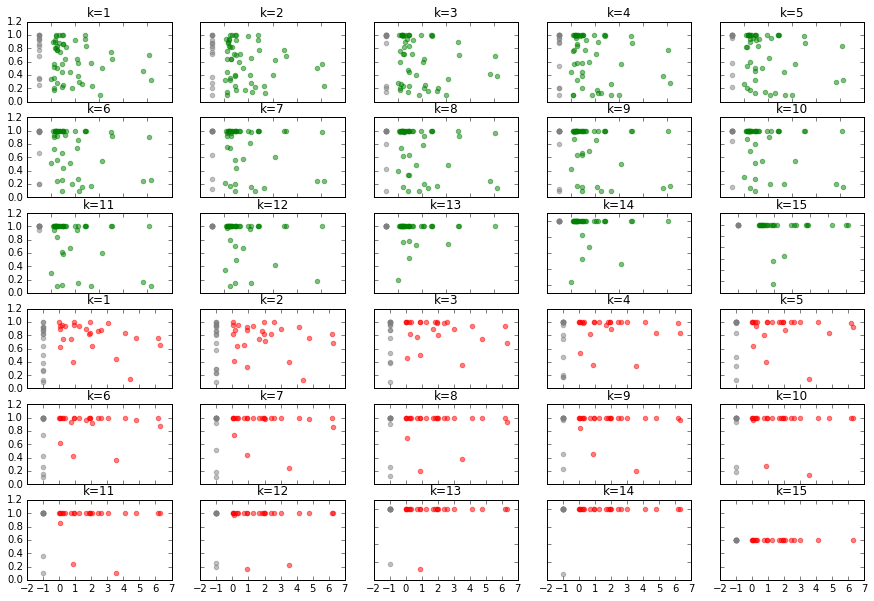

In [53]:
## Fine-tune figure; hide x ticks for top plots and y ticks for right plots
mplot.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[2, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[3, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[4, :]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 4]], visible=False)
mplot.show()

### Supplemental Figure
Check to see if there's a different distribution for concepts which were deemed to be unrelated vs 'non-broken' concepts that were deemed to be related.  Since there are only 11 cpmids in the quality checked set deemed to be unrelated, this is extra step is not included in the main analysis but instead treated as a supplemental analysis.

In [38]:
f, axarr = mplot.subplots(6, 5,figsize=(15,10))
i=0
while i<15:
    j=i+1
    tmpplotdata = related[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[related['k']==j].copy()
    tmpbrkdata = unrelated[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[unrelated['k']==j].copy()
    tmpnb_missing = related_missing[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[related_missing['k']==j].copy()
    tmpb_missing = unrelated_missing[['avg_accuracy','max_accuracy','k','cpmid','sent_diff','word_diff']].loc[unrelated_missing['k']==j].copy()
    
    if i>14:
        break
    elif i <= 4:
        gridx=0
        gridy=i
    elif 4 < i & i <= 9:
        gridx=1
        gridy=i-5
    else:
        gridx=2
        gridy=i-10
    axarr[gridx, gridy].scatter(x=tmpplotdata["sent_diff"], y=tmpplotdata["avg_accuracy"], color="green", alpha=0.5)
    axarr[gridx, gridy].scatter(x=tmpnb_missing["sent_diff"], y=tmpnb_missing["avg_accuracy"], color="grey", alpha=0.5)
    axarr[gridx, gridy].set_title('k='+str(j))
    axarr[(gridx+3), gridy].scatter(x=tmpbrkdata["sent_diff"], y=tmpbrkdata["avg_accuracy"], color="blue", alpha=0.5)
    axarr[gridx+3, gridy].scatter(x=tmpb_missing["sent_diff"], y=tmpb_missing["avg_accuracy"], color="grey", alpha=0.5)
    axarr[(gridx+3), gridy].set_title('k='+str(j))
    i=i+1

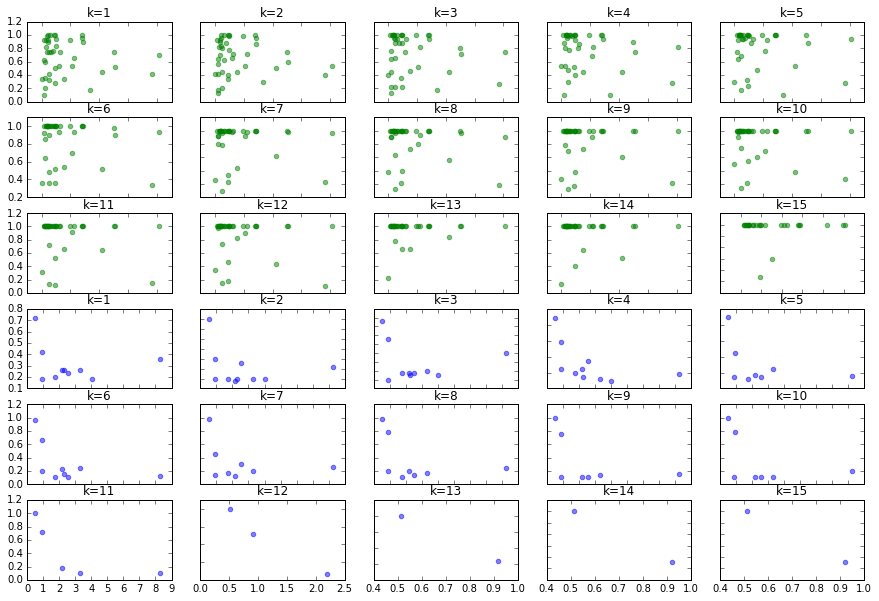

In [39]:
## Fine-tune figure; hide x ticks for top plots and y ticks for right plots
mplot.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[2, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[3, :]], visible=False)
mplot.setp([a.get_xticklabels() for a in axarr[4, :]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)
mplot.setp([a.get_yticklabels() for a in axarr[:, 4]], visible=False)
mplot.show()